In [1]:
from ipywidgets import interactive
import os
import matplotlib.pyplot as plt
import numpy as np
from sem_image import SEM_image
from tqdm import tqdm

from scipy.ndimage import gaussian_filter

In [2]:
%matplotlib notebook

In [3]:
BATCH = 'Batch 220301'


#load SEM data
filenames = []
for file in os.listdir('./data/' + BATCH + '/'):
    if file.endswith('.tif'):
        filenames.append(file[:-4])
filenames.sort()
SEM = {}
for name in tqdm(filenames):
    #SEM[name] = SEM_image('./'+name, Y_PXLS) # <- use this function to cut off scalebar (set Y_PXLS)
    SEM[name] = SEM_image('./data/' + BATCH + '/'+name)
    SEM[name].calculate_fft2D()
    SEM[name].calculate_radial_fft(N=500, R_min=6, R_max=12)
    SEM[name].fit_RDF()

 13%|█▎        | 2/15 [00:02<00:18,  1.39s/it]/home/christian/Nextcloud/PhD/Code/SEM_analysis_NP/sem_image.py:10: RuntimeWarning: overflow encountered in exp
  return ampl*1/(1+np.exp((A-r)/B))*(1+r*np.exp((A-r)/B)/(3*B*(1+np.exp((A-r)/B))))+off
/home/christian/Nextcloud/PhD/Code/SEM_analysis_NP/sem_image.py:10: RuntimeWarning: invalid value encountered in true_divide
  return ampl*1/(1+np.exp((A-r)/B))*(1+r*np.exp((A-r)/B)/(3*B*(1+np.exp((A-r)/B))))+off
100%|██████████| 15/15 [00:21<00:00,  1.40s/it]


<IPython.core.display.Javascript object>


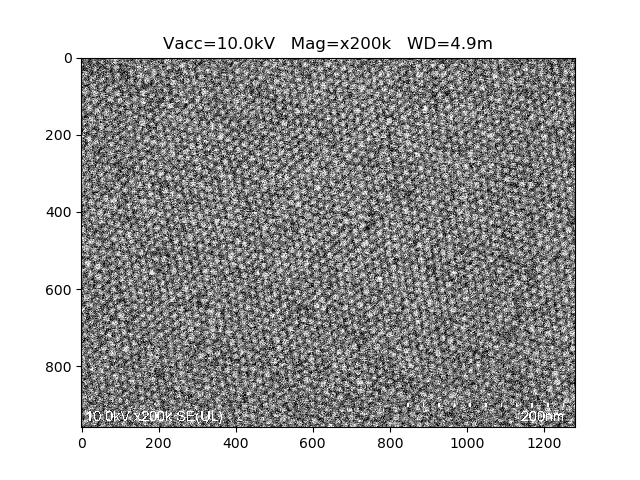

interactive(children=(Dropdown(description='name', options=('C5_0004', 'C5_0008', 'C5_0012', 'C5_0016', 'C6_00…

In [4]:
fig0,ax0 = plt.subplots()
def update_plot(name):
    SEM[name].show_image(fig0, ax0)
display(interactive(update_plot, name=filenames))

<IPython.core.display.Javascript object>


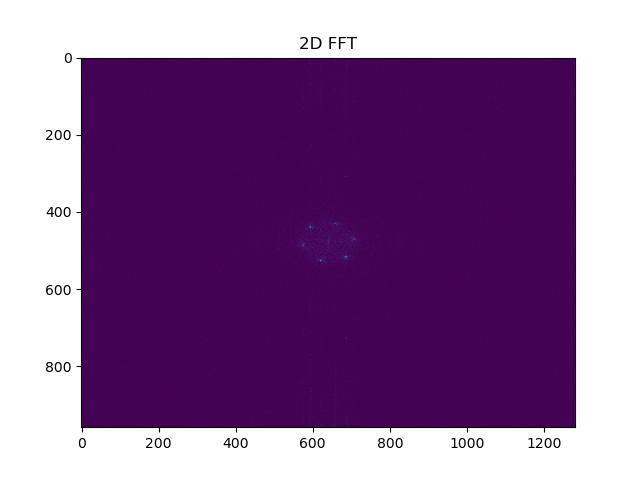

interactive(children=(Dropdown(description='name', options=('C5_0004', 'C5_0008', 'C5_0012', 'C5_0016', 'C6_00…

In [5]:
fig1,ax1 = plt.subplots()
def update_plot(name):
    SEM[name].show_fft2D(fig1, ax1)
display(interactive(update_plot, name=filenames))

#For scaled FFT images, use the following function instead (slow):
#    SEM[name].show_fft2D_scaled(fig, ax)

<IPython.core.display.Javascript object>


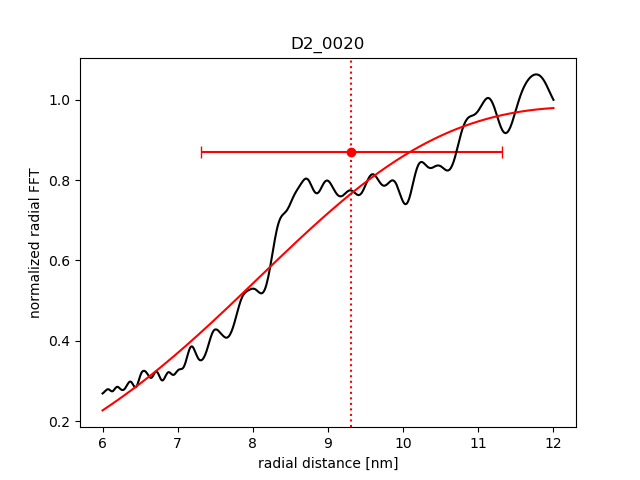

interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',…

In [7]:
fig2,ax2 = plt.subplots()
def update_plot(i=0):
    name=filenames[i]
    SEM[name].show_RDF_fit(fig2,ax2)
    ax2.set_title(name)
display(interactive(update_plot, i=(0,len(filenames)-1)))

In [8]:
#setup for summarizing graphs

def get_color(name):
    if ('0min' == name[:4]) or ('00min' == name[:5]): return 'k'
    elif ('2min' == name[:4]) or ('02min' == name[:5]): return 'steelblue'
    elif ('4min' == name[:4]) or ('04min' == name[:5]): return 'limegreen'
    elif ('6min' == name[:4]) or ('06min' == name[:5]): return 'forestgreen'
    elif ('8min' == name[:4]) or ('08min' == name[:5]): return 'blue'
    elif ('10min' == name[:4]) or ('10min' == name[:5]): return 'yellow'
    else: return 'r'

#summarize results
keys = ['00min', '02min', '04min', '06min','08min','10min']

results, avg_results, avg_sigma = {},{},{}
for key in keys:
    results[key] = []
    for name in filenames:
        if (key == name[:4]) or (key == name[:5]):
            results[key].append(SEM[name].popt_RDF[0])
    avg_results[key] = np.nanmean(results[key])
    avg_sigma[key] = np.std(results[key])

<ipython-input-8-cb5a1d24a206>:21: RuntimeWarning: Mean of empty slice
  avg_results[key] = np.nanmean(results[key])
/home/christian/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/christian/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/christian/.local/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


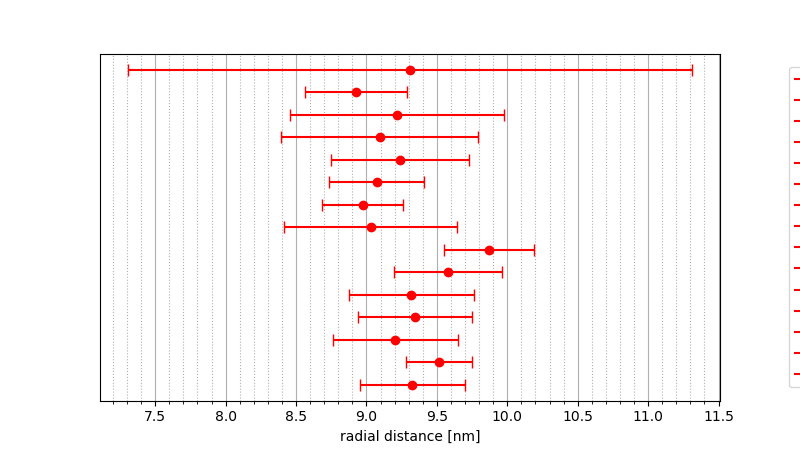

[]

In [9]:
#plot results

fig3,ax3 = plt.subplots(figsize=(8,len(filenames)*0.3))

for i,name in enumerate(filenames):
    ax3.errorbar(SEM[name].popt_RDF[0], i, xerr=SEM[name].popt_RDF[1], 
                label=SEM[name].name, color=get_color(SEM[name].name), marker='o', capsize=4)

ax3.minorticks_on()
ax3.grid(axis = 'x', which='both')
ax3.grid(axis = 'x', which='minor', linestyle=':')
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax3.set_xlabel('radial distance [nm]')
ax3.set_yticks([])

<IPython.core.display.Javascript object>


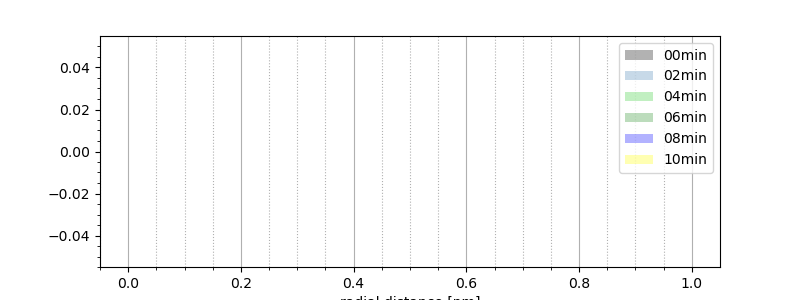

Text(0.5, 0, 'radial distance [nm]')

In [10]:
#histogram

fig4,ax4 = plt.subplots(figsize=(8,3))
for key in keys:
    ax4.hist(results[key], color=get_color(key), label=key, alpha=0.3)

ax4.minorticks_on()
ax4.grid(axis = 'x', which='both')
ax4.grid(axis = 'x', which='minor', linestyle=':')
ax4.legend()
ax4.set_xlabel('radial distance [nm]')

<IPython.core.display.Javascript object>


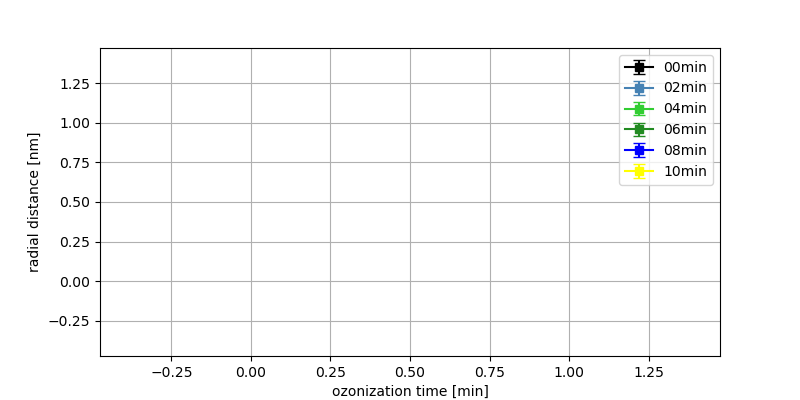

Text(0, 0.5, 'radial distance [nm]')

In [12]:
#curve

fig5,ax5 = plt.subplots(figsize=(8,4))

ax5.plot([float(key.split('m')[0]) for key in keys], [avg_results[key] for key in keys], color='k')
for key in keys:
    ax5.errorbar(float(key.split('m')[0]), avg_results[key],yerr=avg_sigma[key],
                capsize=4, color=get_color(key), marker='s', label=key)
    
ax5.legend()
ax5.grid()
ax5.set_xlabel('ozonization time [min]')
ax5.set_ylabel('radial distance [nm]')